In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

## Exploratory Data Analysis

In [6]:
df = pd.read_csv("allSeasons.csv")
df["FTR_numeric"] = df["FTR"].map({"H": 0, "D": 1, "A": 2})
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%y")
df.shape

(4081, 24)

Loads the dataset and maps the Full time result (`FTR`) to numeric values (Home win: 0, Draw: 1, Away win: 2). The dataset contains 24 different coloumns, with 4081 different matches. The dataset consist of 10 full seasons (2014/15 – 2023/34) and 281 matches from the 2024/25 season. Given its medium size (4081 matches and 24 features), traditional machine learning models like Random Forest, XGBoost, and logistic regression are suitable choices for classification.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4081 entries, 0 to 4080
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   4081 non-null   int64         
 1   Date         4081 non-null   datetime64[ns]
 2   HomeTeam     4081 non-null   object        
 3   AwayTeam     4081 non-null   object        
 4   FTHG         4081 non-null   int64         
 5   FTAG         4081 non-null   int64         
 6   FTR          4081 non-null   object        
 7   HTHG         4081 non-null   int64         
 8   HTAG         4081 non-null   int64         
 9   HTR          4081 non-null   object        
 10  Referee      4081 non-null   object        
 11  HS           4081 non-null   int64         
 12  AS           4081 non-null   int64         
 13  HST          4081 non-null   int64         
 14  AST          4081 non-null   int64         
 15  HF           4081 non-null   int64         
 16  AF    

In [8]:
df.describe()

,Unnamed: 0,Date,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,FTR_numeric
count,4081.000000,4081,4081.000000,4081.000000,4081.000000,4081.000000,4081.000000,4081.000000,4081.000000,4081.000000,4081.000000,4081.000000,4081.000000,4081.000000,4081.000000,4081.000000,4081.000000,4081.000000,4081.000000
mean,186.091644,2019-11-22 00:12:20.994854144,1.545945,1.260475,0.697378,0.561137,14.000980,11.467287,4.784367,3.990198,10.607449,10.961774,5.764028,4.712325,1.633178,1.815731,0.056359,0.069346,0.873805
min,0.000000,2014-08-16 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,92.000000,2017-03-04 00:00:00,1.000000,0.000000,0.000000,0.000000,10.000000,8.000000,3.000000,2.000000,8.000000,8.000000,3.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,185.000000,2019-12-03 00:00:00,1.000000,1.000000,0.000000,0.000000,13.000000,11.000000,4.000000,4.000000,10.000000,11.000000,5.000000,4.000000,1.000000,2.000000,0.000000,0.000000,1.000000
75%,278.000000,2022-08-20 00:00:00,2.000000,2.000000,1.000000,1.000000,17.000000,15.000000,6.000000,5.000000,13.000000,13.000000,8.000000,6.000000,2.000000,3.000000,0.000000,0.000000,2.000000
max,379.000000,2025-03-10 00:00:00,9.000000,9.000000,5.000000,5.000000,43.000000,37.000000,17.000000,15.000000,24.000000,26.000000,19.000000,19.000000,7.000000,9.000000,2.000000,2.000000,2.000000
std,108.709500,NaN,1.317830,1.205798,0.851363,0.774121,5.721177,4.988759,2.639270,2.345396,3.448257,3.579559,3.120527,2.746400,1.264123,1.299267,0.238992,0.260738,0.866027


In [9]:
df.tail()

,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,FTR_numeric
4076,276,2025-03-08,Wolves,Everton,1,1,D,1,1,D,...,4,11,16,5,5,2,2,0,0,1
4077,277,2025-03-09,Chelsea,Leicester,1,0,H,0,0,D,...,3,12,13,12,2,1,0,0,0,0
4078,278,2025-03-09,Tottenham,Bournemouth,2,2,D,0,1,A,...,8,15,16,3,6,3,3,0,0,1
4079,279,2025-03-09,Man United,Arsenal,1,1,D,1,0,H,...,6,8,11,2,9,0,1,0,0,1
4080,280,2025-03-10,West Ham,Newcastle,0,1,A,0,0,D,...,3,7,15,3,4,0,1,0,0,2


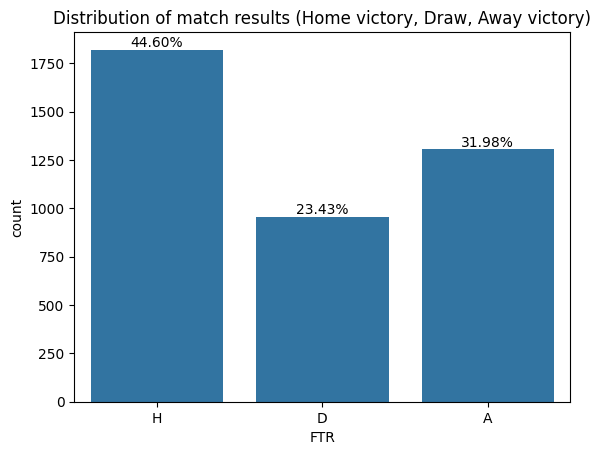

In [10]:
normalized_values = [f"{value*100:.2f}%" for value in df['FTR_numeric'].value_counts(normalize=True, sort=False)] 
ax = sns.countplot(x=df["FTR"])
ax.bar_label(container=ax.containers[0], labels=normalized_values)
plt.title("Distribution of match results (Home victory, Draw, Away victory)")
plt.show()


We see a fairly balanced distribution, but an advantage to teams playing at home. 

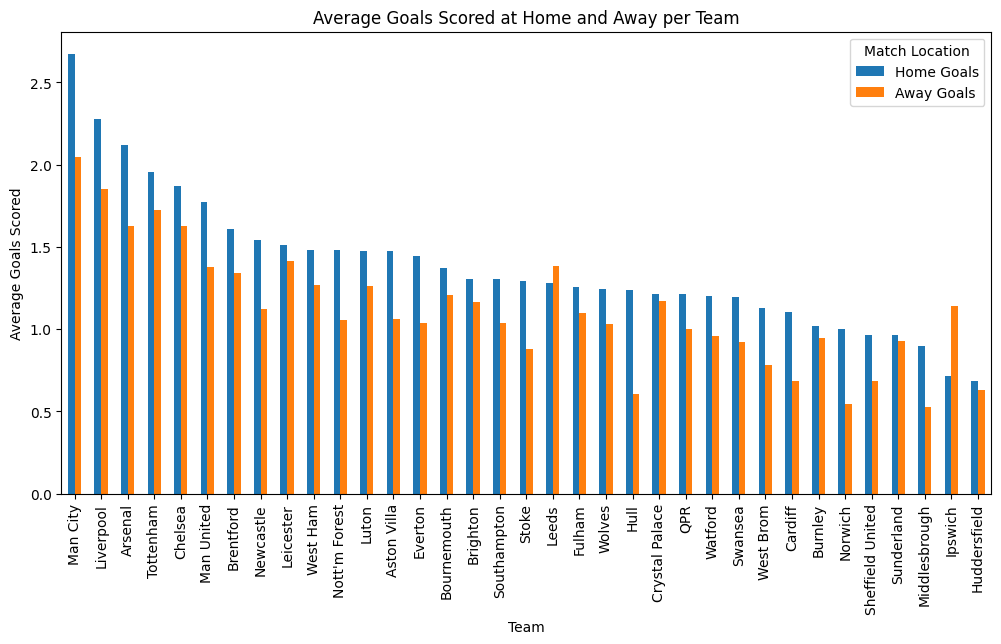

In [11]:
home_goals = df.groupby("HomeTeam")["FTHG"].mean()
away_goals = df.groupby("AwayTeam")["FTAG"].mean()

goals_df = pd.DataFrame({"Home Goals": home_goals, "Away Goals": away_goals})
goals_df = goals_df.sort_values("Home Goals", ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
goals_df.plot(kind="bar", ax=ax)  

ax.set_ylabel("Average Goals Scored")
ax.set_xlabel("Team")
ax.set_title("Average Goals Scored at Home and Away per Team")
plt.xticks(rotation=90)  
plt.legend(title="Match Location")

plt.show()

This provides an overview of all the teams that have taken part in the Premier League from 14/15 to 24/25. It futher showcases how more effective teams playing at home are. 

In [12]:
features_corr_matrix = ["FTHG", "FTAG", "HS", "AS", "HST", "HF", "AF", "AST", "HC", "AC", "HY", "AY", "HR", "AR"]


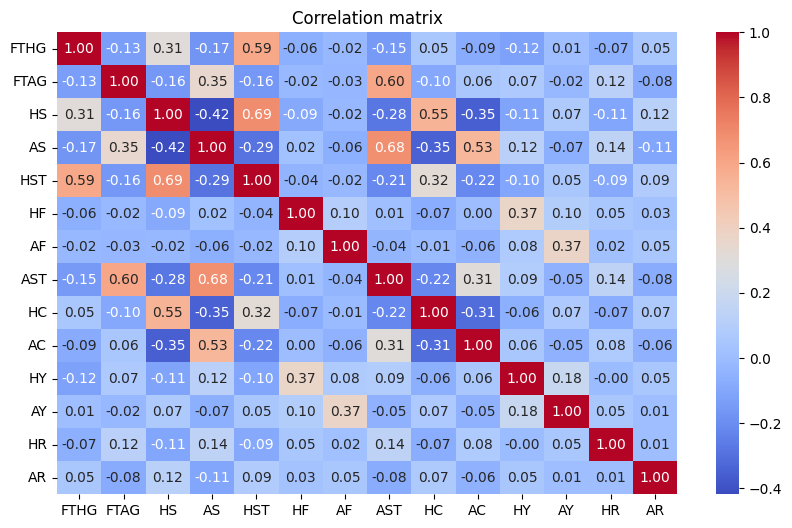

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[features_corr_matrix].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix")
plt.show()


Home and Away corners, as well as variables related to fouls and cards, show little statistical impact on match outcomes. However, we observe that total shots (HS, AS) have a relatively weaker effect compared to shots on target (HST, AST), which appear to be more strongly correlated with goals scored (FTHG, FTAG).

### Elo-rating

This script implements an Elo rating system to evaluate the strength of football teams based on match results.
The Elo system originates from chess and dynamically adjusts team ratings after each match.

Key components:
- INITIAL_ELO: Default rating for new or promoted teams.
- K: Adjustment factor, controlling how much ratings change per match.
- C: Scaling factor to adjust the influence of match results on rating changes.

The system updates Elo ratings after each match based on the difference in team ratings and actual match outcomes.

In [14]:
C = 1000  # Scaling factor for rating changes
K = 32  # Adjustment factor controlling rating updates

In [15]:
# Initial values for Elo-rating
INITIAL_ELO = 1500  # Default rating for new teams

# Dictionary to store team ratings
team_ratings = {}

def get_team_rating(team):
    """
    Returns the Elo rating of a given team.
    If the team is not in the dictionary (e.g., a newly promoted team), it starts with INITIAL_ELO.
    """
    return team_ratings.get(team, INITIAL_ELO)

def update_elo_rating(home_team, away_team, home_score, away_score):
    """
    Updates the Elo ratings for both home and away teams based on match results.
    """
    global team_ratings
    
    # Fetch current Elo ratings
    R_home = get_team_rating(home_team) 
    R_away = get_team_rating(away_team)
    
    # Compute rating differences
    D_home = R_away - R_home
    D_away = R_home - R_away
    
    # Compute expected outcome probabilities (E)
    E_home = 1 / (1 + 10 ** (D_home / 400))
    E_away = 1 / (1 + 10 ** (D_away / 400))
    
    # Determine actual match outcome (S)
    if home_score > away_score:
        S_home, S_away = 1, 0  # Home team wins
    elif home_score < away_score:
        S_home, S_away = 0, 1  # Away team wins
    else:
        S_home, S_away = 0.5, 0.5  # Draw
    
    # Compute updated Elo ratings
    R_new_home = R_home + K * (S_home - E_home) - (K / (4 * C)) * D_home
    R_new_away = R_away + K * (S_away - E_away) - (K / (4 * C)) * D_away
    
    # Store updated ratings
    team_ratings[home_team] = R_new_home
    team_ratings[away_team] = R_new_away

# Create new columns for Elo ratings before each match
df["home_elo"] = np.nan
df["away_elo"] = np.nan

# Loop through dataset and update Elo ratings
for i, row in df.iterrows():
    home_team = row["HomeTeam"]
    away_team = row["AwayTeam"]
    home_score = row["FTHG"]  # Full-time home goals
    away_score = row["FTAG"]  # Full-time away goals
    
    # Assign pre-match Elo ratings to the dataset
    df.at[i, "home_elo"] = get_team_rating(home_team)
    df.at[i, "away_elo"] = get_team_rating(away_team)
    
    # Update Elo ratings after the match result
    update_elo_rating(home_team, away_team, home_score, away_score)

# Fill NaN values (likely in the first few matches where teams haven't played yet) with INITIAL_ELO
df.fillna(INITIAL_ELO, inplace=True)


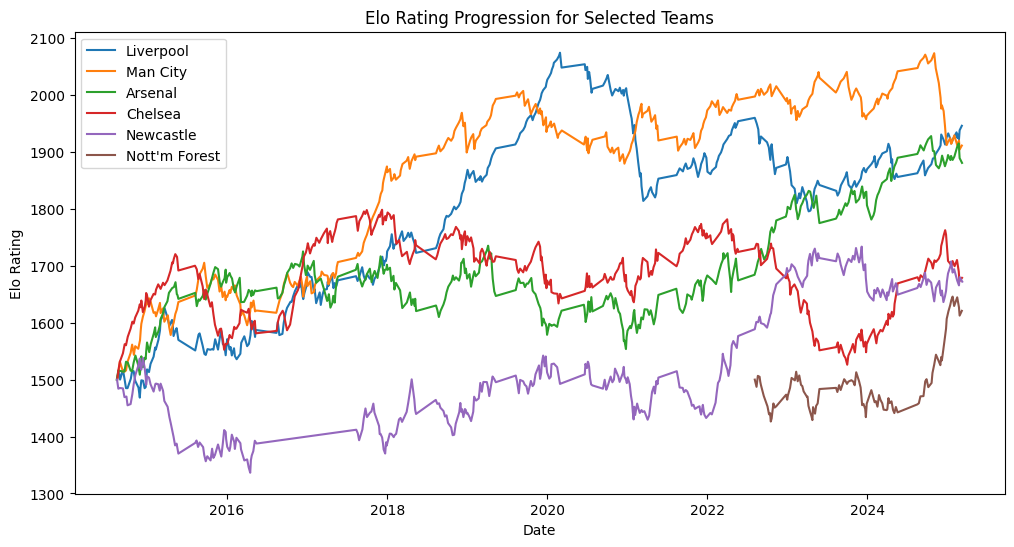

In [16]:
elo_history = []  # List to store Elo rating history for all teams

# Iterate through the dataset and update Elo ratings
for i, row in df.iterrows():
    home_team = row["HomeTeam"]
    away_team = row["AwayTeam"]
    date = row["Date"]  # Match date
    
    home_elo = row["home_elo"]  # Home team's Elo before the match
    away_elo = row["away_elo"]  # Away team's Elo before the match
    
    # Store the Elo ratings for both teams on the given match date
    elo_history.append({"Date": date, "Team": home_team, "Elo": home_elo})
    elo_history.append({"Date": date, "Team": away_team, "Elo": away_elo})
    
# Convert the Elo history list into a DataFrame
elo_df = pd.DataFrame(elo_history)

# Sort Elo ratings chronologically for each team
elo_df.sort_values(by=["Team", "Date"], inplace=True)

# Define the teams to visualize in the Elo rating progression
selected_teams = ["Liverpool", "Man City", "Arsenal", "Chelsea", "Newcastle", "Nott'm Forest"]

plt.figure(figsize=(12, 6))

# Plot Elo rating progression for each selected team
for team in selected_teams:
    team_data = elo_df[elo_df["Team"] == team]  # Filter data for the specific team
    plt.plot(team_data["Date"], team_data["Elo"], label=team)  # Plot Elo over time

# Set plot labels and title
plt.xlabel("Date")
plt.ylabel("Elo Rating")
plt.title("Elo Rating Progression for Selected Teams")

# Display the legend
plt.legend()

# Show the plot
plt.show()


This plot illustrates the Elo rating progression of selected teams over time, highlighting how teams like Liverpool and Man City have consistently performed at a high level, maintaining strong ratings. Additionally, it showcases how promoted teams, such as Nottingham Forest, experience significant rating fluctuations, with a sharp increase in the recent year. The graph also reflects periods of dominance, decline, and resurgence for other teams like Arsenal, Chelsea, and Newcastle.

### Feature engeering

In [17]:
rolling_window = 5

# Calculate rolling average of goals scored in the last 5 matches
df["home_goals_last_5"] = df.groupby("HomeTeam")["FTHG"].transform(lambda x: x.rolling(rolling_window, min_periods=1).mean())
df["away_goals_last_5"] = df.groupby("AwayTeam")["FTAG"].transform(lambda x: x.rolling(rolling_window, min_periods=1).mean())

# Calculate rolling average of goals conceded in the last 5 matches
df["home_conceded_last_5"] = df.groupby("HomeTeam")["FTAG"].transform(lambda x: x.rolling(rolling_window, min_periods=1).mean())
df["away_conceded_last_5"] = df.groupby("AwayTeam")["FTHG"].transform(lambda x: x.rolling(rolling_window, min_periods=1).mean())

# Assign points based on match result:
df["home_points"] = df["FTR"].map({"H": 3, "D": 1, "A": 0})
df["away_points"] = df["FTR"].map({"H": 0, "D": 1, "A": 3})

# Compute rolling average of points earned in the last 5 matches
df["home_points_last_5"] = df.groupby("HomeTeam")["home_points"].transform(lambda x: x.rolling(rolling_window, min_periods=1).mean())
df["away_points_last_5"] = df.groupby("AwayTeam")["away_points"].transform(lambda x: x.rolling(rolling_window, min_periods=1).mean())


In [18]:
df1 = df.copy()
df2 = df.copy()

# Calculate rest days for home teams
df1 = df1.sort_values(by=["HomeTeam", "Date"]).reset_index(drop=True) 
df["home_rest_days"] = df1.groupby("HomeTeam")["Date"].diff().dt.days.fillna(7)  # Compute days since last match, fill NaN with 7 days 

# Calculate rest days for away teams
df2 = df2.sort_values(by=["AwayTeam", "Date"]).reset_index(drop=True)  
df["away_rest_days"] = df2.groupby("AwayTeam")["Date"].diff().dt.days.fillna(7)  # Compute days since last match, fill NaN with 7 days

In [19]:
selected_features = ['home_elo', 'away_elo', 'home_goals_last_5', 'away_goals_last_5', 'home_conceded_last_5',
       'away_conceded_last_5',
       'home_points_last_5', 'away_points_last_5', 'home_rest_days', 'away_rest_days']

## Training and testing

In [20]:
# Split the dataset into training and test sets
df_train = df.iloc[:-281]  
df_test = df.iloc[-281:]   

X_train = df_train[selected_features]
y_train = df_train['FTR_numeric']
X_test = df_test[selected_features]
y_test = df_test['FTR_numeric']

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

# Print classification report
print("Random Forest:")
print(classification_report(y_test, y_pred, target_names=["Home Win", "Draw", "Away Win"]))


Model accuracy: 0.69
Random Forest:
              precision    recall  f1-score   support

    Home Win       0.71      0.82      0.76       112
        Draw       0.63      0.31      0.42        70
    Away Win       0.69      0.82      0.75        99

    accuracy                           0.69       281
   macro avg       0.68      0.65      0.64       281
weighted avg       0.68      0.69      0.67       281



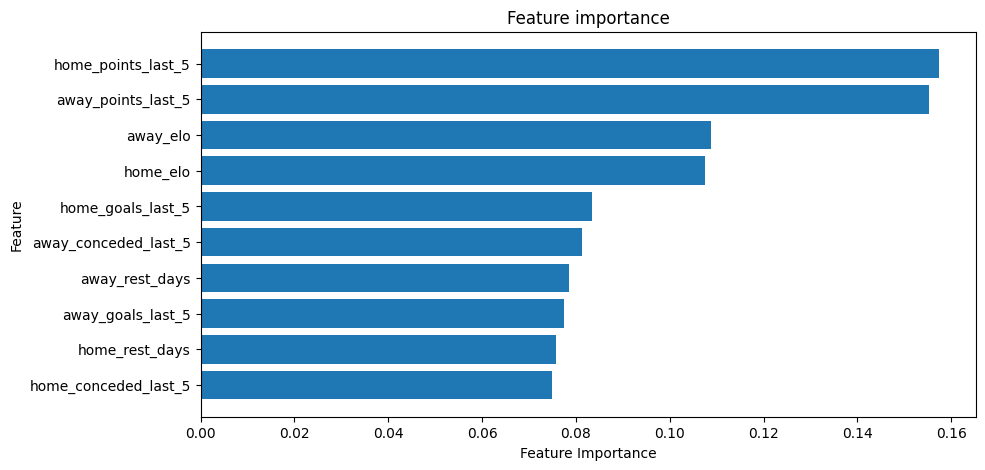

In [21]:
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,5))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature importance")
plt.gca().invert_yaxis()
plt.show()

In [22]:
# Find how often each outcome type occurs in the training data
baseline_probs = df_train['FTR_numeric'].value_counts(normalize=True)

# Calculate accuracy if we always predict the most probable outcome
baseline_accuracy = baseline_probs.max()
print(f"Baseline accuracy (most probable outcome): {baseline_accuracy:.2f}")


Baseline accuracy (most probable outcome): 0.45


### XGBoost

In [23]:
# xgb_model = XGBClassifier(
#     use_label_encoder=False, 
#     eval_metric="mlogloss",
#     n_estimators=200,  #Øk antall trær for bedre læring
#     learning_rate=0.05,  #Lavere learning rate for mer stabile prediksjoner
#     max_depth=4,  # Begrens dybden på trærne for å unngå overfitting
#     subsample=0.8,  # Bruk 80% av dataene for hver iterasjon (reduserer overfitting)
#     colsample_bytree=0.8  # Bruk 80% av features for hver iterasjon
# )

# xgb_model.fit(X_train, y_train)


In [24]:
# y_pred = xgb_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"XGBoost-modellens nøyaktighet: {accuracy:.2f}")

# # Detaljert rapport
# print("XGBoost: ")
# print(classification_report(y_test, y_pred, target_names=["Hjemmeseier", "Uavgjort", "Borteseier"]))


In [25]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 4, 5],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9]
# }

# grid_search = GridSearchCV(
#     XGBClassifier(eval_metric="mlogloss"),
#     param_grid,
#     scoring='accuracy',
#     cv=3,
#     verbose=1
# )

# grid_search.fit(X_train, y_train)
# print("Beste hyperparametere:", grid_search.best_params_)


Beste hyperparametere: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.9}

In [26]:
#best_model = grid_search.best_estimator_
# best_model = XGBClassifier(
#     use_label_encoder=False, 
#     eval_metric="mlogloss",
#     n_estimators=100,  
#     learning_rate=0.1,  
#     max_depth=4,  
#     subsample=0.9,  
#     colsample_bytree=0.9
# )
# best_model.fit(X_train, y_train)

# y_pred = best_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(classification_report(y_test, y_pred, target_names=["Hjemmeseier", "Uavgjort", "Borteseier"]))

# df_test_results = df_test.copy()
# df_test_results["Actual_Result"] = y_test.map({0: "Hjemmeseier", 1: "Uavgjort", 2: "Borteseier"})
# df_test_results["Predicted_Result"] = best_model.predict(X_test)
# df_test_results["Predicted_Result"] = df_test_results["Predicted_Result"].map({0: "Hjemmeseier", 1: "Uavgjort", 2: "Borteseier"})

# print(df_test_results[["Date", "HomeTeam", "AwayTeam", "Actual_Result", "Predicted_Result"]].tail(20))
